In [111]:
import sys

sys.path.append('../')
import os
import requests
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials
from dotenv import load_dotenv
import pandas as pd
import json
from custom_utils import print_pretty_json
from IPython.display import JSON
import json
import pprint
import numpy as np
import pickle
from sklearn import datasets  # sklearn comes with some toy datasets to practise
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from matplotlib import pyplot
from sklearn.metrics import silhouette_score

load_dotenv()

True

In [361]:
hot_playlists = [
    '37i9dQZF1DXcBWIGoYBM5M',
    '31ymdYCITDnZRtkKzP3Itp',
    '0cc8YMQWsSzODyTpdVB6mI',
    '37i9dQZF1DX5hHfOi73rY3',
    '37i9dQZF1DXa71eg5j9dKZ',
    '4kw9kdjzx1UmyWvpysl0y2',
    '1xNWydoMmA8210KeHU948w',
    '6vDGVr652ztNWKZuHvsFvx',
    '6J1r02xyO2qkMA9dDNZytJ',
    '5wtqmpRl17iVz2nW8U6njL',
    '0NCspsyf0OS4BsPgGhkQXM',
    '19y0UVk0bcrJWEqMwBHosj',
    '4oOZJEq1TBUti6PSouTo5M',
    '6ZTpgxK6BT92mmsqwETj9l',
    '37i9dQZF1DWSvKsRPPnv5o',
    '37i9dQZF1DXe4Cw8IKKIvr',
    # '65xSncKQzG6Suseh5gfYP1',
    # '37i9dQZF1DXcDoDDetPsEg',
    # '0MSCX9tZWQmitMQsfhvZIl',
    # '1PmwMQY86pJuAm7veFt3u2',
    # '6wjCvkAFovrVIRM8VfZLZG',
    # '37i9dQZF1DWVV27DiNWxkR',
    # '37i9dQZF1DXc8kgYqQLMfH',
    # '31FWVQBp3WQydWLNhO0ACi',
    # '37i9dQZF1DXa9wYJr1oMFq'
]
# hot_playlists = [
#     '37i9dQZF1DX2yvmlOdMYzV'
# ]

functions

In [362]:
def df_cleaner(df):
    df.drop_duplicates('name', inplace=True)
    df = df.drop(
        [
            'album',
            'artists',
            'available_markets',
            'disc_number',
            'explicit',
            'external_ids',
            'external_urls',
            'href',
            'id',
            'is_local',
            '...',
            'track_href',
            'analysis_url',
            'uri',
            'preview_url',
            'type',
            'name',
            'preview_url',
        ],
        errors='ignore',
        axis='columns'
    )

    df = df.reindex(sorted(df.columns), axis=1)

    return df


def get_top_tracks(max_page, per_page, keyword):
    current_offset = 1
    final_data = []
    results = sp.search(q='top', limit=per_page, type="track")
    final_results = results['tracks']['items']

    while current_offset <= max_page and results['tracks'].get('next', ''):
        current_offset += 1
        results = sp.search(q=keyword, offset=current_offset)
        final_results.extend(results['tracks']['items'])

    for i in final_results:
        audio_features = sp.audio_features(i["uri"])
        # print(audio_features)
        final_data.append({**i, **audio_features[0]})

    return final_data


def get_playlist_tracks(username, playlist_id):
    results = sp.user_playlist_tracks(username, playlist_id, market="GB")
    tracks = results['tracks']['items']
    while results['next']:
        results = sp.next(results)
        tracks.extend(results['tracks']['items'])
    return tracks


def get_playlists_data(playlists):
    try:
        final_data = []
        final_results = []
        for playlist in playlists:
            results = sp.playlist_tracks(playlist_id=playlist)
            tracks_filtered = list(filter(lambda x: x is not None ,results['items']))
            tracks = list(map(lambda x:x['track'],tracks_filtered))
            if results.get('next', False) or False:
                while results.get('next', False) or False:
                    try:
                        results = sp.next(results)
                        tracks_filtered = list(filter(lambda x: x is not None ,results['items']))
                        tracks = list(map(lambda x:x['track'],tracks_filtered))
                        # tracks.extend(list(map(lambda x:x['track'],results['items'])))
                    except KeyError:
                       break
            final_results.extend(tracks)

        # data_with_uri = list(filter(lambda x:'uri' in x.keys(),final_results))
        data_with_uri = list(filter(lambda x: x is not None ,final_results))
        for i in data_with_uri:
            try:
                audio_features = sp.audio_features(i["uri"])
                final_data.append({**i, **audio_features[0]})
            except KeyError:
                break

        return final_data

    except OSError:
        print(str(OSError))


In [363]:
playlists_data = get_playlists_data(hot_playlists)
df = pd.DataFrame(playlists_data)
df.to_csv('spotify_data.csv', index=False, encoding='utf-8')
print('saved')

saved


In [364]:
len(playlists_data)

856

   #final_data = map(lambda i: {**i, **(sp.audio_features(i["uri"]))}, final_data)

In [113]:
sp = spotipy.Spotify(
    auth_manager=SpotifyClientCredentials(
        client_id=os.getenv("SPOTIFY_CLIENT_ID"),
        client_secret=os.getenv("SPOTIFY_API_KEY")
    ))

In [114]:
# per_page = 30
# max_page = 40
#
# pop = pd.DataFrame(get_top_tracks(max_page=max_page, per_page=per_page, keyword='pop'))
# rock = pd.DataFrame(get_top_tracks(max_page=max_page, per_page=per_page, keyword='rock'))
# classic = pd.DataFrame(get_top_tracks(max_page=max_page, per_page=per_page, keyword='classic'))
# folk = pd.DataFrame(get_top_tracks(max_page=max_page, per_page=per_page, keyword='folk'))
# funk = pd.DataFrame(get_top_tracks(max_page=max_page, per_page=per_page, keyword='funk'))
# metal = pd.DataFrame(get_top_tracks(max_page=max_page, per_page=per_page, keyword='metal'))

In [115]:
# df = pd.concat([pop,rock,classic,folk,funk,metal],ignore_index=True)
# df

save df

In [259]:
# playlists_data
# df = pd.DataFrame(playlists_data)
# df.to_csv('spotify_data.csv', index=False, encoding='utf-8')

importing the saved data

In [117]:
baseDf = pd.read_csv('spotify_data.csv')
baseDf = df_cleaner(baseDf)
print(baseDf.columns)
# baseDf

Index(['acousticness', 'danceability', 'duration_ms', 'energy',
       'instrumentalness', 'key', 'liveness', 'loudness', 'mode', 'popularity',
       'speechiness', 'tempo', 'time_signature', 'track_number', 'valence'],
      dtype='object')


In [118]:
X = pd.DataFrame(baseDf, columns=list(baseDf.columns))
scaler = StandardScaler()
scaler.fit(X)
X_scaled = scaler.transform(X)
X_scaled_df = pd.DataFrame(X_scaled, columns=X.columns)
X_scaled_df.describe()

,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,popularity,speechiness,tempo,time_signature,track_number,valence
count,3.060000e+02,3.060000e+02,3.060000e+02,3.060000e+02,3.060000e+02,3.060000e+02,3.060000e+02,3.060000e+02,3.060000e+02,3.060000e+02,3.060000e+02,3.060000e+02,3.060000e+02,3.060000e+02,3.060000e+02
mean,8.127123e-17,-3.250849e-16,1.161018e-16,4.063561e-17,2.322035e-17,-4.934325e-17,3.483053e-17,2.322035e-17,8.997886e-17,4.644070e-17,6.966105e-17,3.308900e-16,-5.747037e-16,1.741526e-17,-4.165150e-16
std,1.001638e+00,1.001638e+00,1.001638e+00,1.001638e+00,1.001638e+00,1.001638e+00,1.001638e+00,1.001638e+00,1.001638e+00,1.001638e+00,1.001638e+00,1.001638e+00,1.001638e+00,1.001638e+00,1.001638e+00
min,-8.364679e-01,-2.712617e+00,-2.250226e+00,-2.712530e+00,-3.756271e-01,-1.429368e+00,-1.050369e+00,-5.859161e+00,-1.513381e+00,-4.335741e+00,-8.513483e-01,-1.990176e+00,-7.851359e+00,-6.122209e-01,-1.863289e+00
25%,-7.811468e-01,-7.110989e-01,-6.037067e-01,-5.657232e-01,-3.756271e-01,-8.795422e-01,-6.143210e-01,-2.195994e-01,-1.513381e+00,-3.917745e-01,-6.879734e-01,-8.377431e-01,1.570272e-01,-6.122209e-01,-7.797623e-01
50%,-5.112072e-01,8.287976e-02,-1.370907e-01,1.233146e-01,-3.755582e-01,8.265361e-02,-4.409951e-01,2.602399e-01,6.607721e-01,1.522209e-01,-4.965184e-01,-6.684788e-02,1.570272e-01,-3.051068e-01,-7.907768e-02
75%,4.741601e-01,7.342016e-01,4.511201e-01,7.877821e-01,-3.539705e-01,7.699363e-01,2.449028e-01,5.470354e-01,6.607721e-01,6.962164e-01,3.377150e-01,7.302844e-01,1.570272e-01,1.248529e-01,8.323093e-01
max,2.336472e+00,2.111776e+00,4.903179e+00,1.522756e+00,3.623483e+00,1.594676e+00,5.014450e+00,1.212474e+00,6.607721e-01,2.396202e+00,4.046837e+00,3.026483e+00,2.826489e+00,8.969739e+00,1.853023e+00


In [119]:
kmeans = KMeans(n_clusters=6, random_state=1234)
kmeans.fit(X_scaled_df)

KMeans(n_clusters=6, random_state=1234)

In [120]:
kmeans.labels_

array([2, 5, 5, 1, 5, 2, 2, 3, 5, 5, 5, 3, 1, 5, 1, 5, 2, 1, 5, 3, 5, 3,
       2, 5, 1, 3, 5, 3, 1, 5, 2, 1, 1, 3, 5, 2, 1, 5, 5, 1, 1, 3, 3, 5,
       2, 1, 1, 1, 1, 3, 5, 5, 5, 5, 5, 5, 2, 5, 1, 5, 5, 5, 1, 1, 5, 3,
       5, 1, 1, 5, 5, 5, 2, 5, 3, 5, 5, 2, 5, 3, 1, 1, 2, 5, 5, 1, 1, 5,
       1, 5, 3, 5, 1, 2, 1, 3, 1, 5, 5, 1, 5, 5, 3, 5, 2, 1, 1, 0, 2, 5,
       1, 5, 3, 1, 1, 5, 5, 5, 5, 3, 3, 2, 1, 3, 1, 0, 5, 4, 4, 5, 1, 5,
       2, 2, 4, 4, 4, 5, 4, 2, 2, 5, 5, 2, 5, 5, 5, 5, 3, 2, 4, 3, 2, 1,
       3, 1, 4, 3, 4, 2, 4, 5, 4, 1, 5, 3, 3, 5, 3, 3, 2, 1, 1, 3, 3, 2,
       2, 5, 3, 3, 4, 3, 3, 0, 3, 3, 3, 3, 3, 5, 5, 1, 3, 3, 3, 3, 5, 3,
       3, 3, 2, 3, 5, 2, 3, 3, 3, 2, 3, 5, 3, 5, 5, 1, 5, 1, 1, 1, 1, 5,
       5, 5, 1, 5, 5, 5, 1, 2, 5, 5, 5, 5, 1, 1, 5, 5, 5, 5, 3, 5, 1, 5,
       5, 3, 1, 5, 1, 1, 5, 3, 1, 1, 5, 5, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2,
       1, 2, 2, 3, 2, 3, 2, 2, 2, 2, 5, 2, 2, 2, 2, 2, 2, 2, 2, 5, 2, 1,
       1, 5, 2, 2, 2, 2, 5, 5, 2, 2, 3, 5, 5, 2, 2,

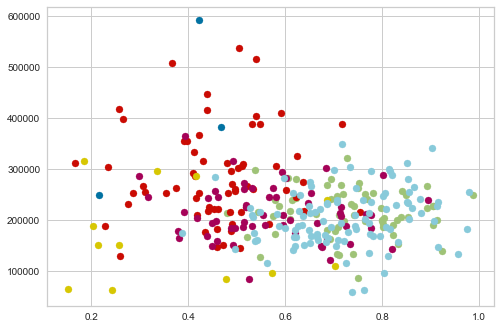

In [121]:
# assign a cluster to each example
labels = kmeans.predict(X_scaled_df)
# retrieve unique clusters
clusters = np.unique(labels)
# create scatter plot for samples from each cluster
for cluster in clusters:
    # get row indexes for samples with this cluster
    row_ix = np.where(labels == cluster)
    # create scatter of these samples
    pyplot.scatter(X.to_numpy()[row_ix, 1], X.to_numpy()[row_ix, 2])
    # show the plot
pyplot.show()

In [122]:
clusters = kmeans.predict(X_scaled_df)
#clusters
pd.Series(clusters).value_counts().sort_index()

0      3
1     64
2     66
3     58
4     12
5    103
dtype: int64

In [123]:
#X_df = pd.DataFrame(X)
X["cluster"] = clusters
X

,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,popularity,speechiness,tempo,time_signature,track_number,valence,cluster
0,0.005870,0.755,215364,0.615,0.000002,4,0.1090,-8.245,1,71,0.0454,105.955,4,1,0.039,2
1,0.082600,0.704,148486,0.797,0.000745,0,0.0546,-5.927,1,90,0.0475,139.994,4,1,0.825,5
2,0.010300,0.906,197420,0.395,0.000195,1,0.1170,-11.277,1,71,0.2060,146.056,4,5,0.376,5
3,0.241000,0.544,215133,0.897,0.000000,3,0.1300,-6.056,0,79,0.0471,157.170,4,5,0.647,1
4,0.193000,0.776,236000,0.762,0.000000,0,0.1800,-4.356,1,66,0.2160,120.039,4,7,0.678,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2539,0.000003,0.259,130187,0.923,0.103000,1,0.1550,-5.530,1,68,0.0908,199.806,4,7,0.593,2
2549,0.004370,0.415,243533,0.908,0.034500,2,0.0820,-9.701,1,72,0.0765,114.816,4,1,0.437,2
2559,0.026500,0.578,238293,0.854,0.001410,6,0.1460,-6.558,0,52,0.0296,101.181,4,2,0.424,1
2569,0.000051,0.265,396987,0.973,0.094200,9,0.2050,-6.129,1,58,0.1730,148.506,4,2,0.270,2


In [124]:
X[X['cluster'] == 2].sample()

,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,popularity,speechiness,tempo,time_signature,track_number,valence,cluster
32,0.00821,0.461,220537,0.897,0.0,3,0.0965,-3.982,0,75,0.092,165.107,4,1,0.358,2


In [125]:
kmeans.inertia_

3015.7315086738836

In [126]:
kmeans2 = KMeans(n_clusters=50,
                 init="k-means++",
                 n_init=50,  # try with 1, 4, 8, 20, 30, 100...
                 max_iter=10,
                 tol=0,
                 algorithm="elkan",
                 random_state=1234)
kmeans2.fit(X_scaled_df)
print(kmeans2.inertia_)

1234.9552540322786


Training a K-Means model with 2 clusters! 

Training a K-Means model with 3 clusters! 

Training a K-Means model with 4 clusters! 

Training a K-Means model with 5 clusters! 

Training a K-Means model with 6 clusters! 

Training a K-Means model with 7 clusters! 

Training a K-Means model with 8 clusters! 

Training a K-Means model with 9 clusters! 

Training a K-Means model with 10 clusters! 

Training a K-Means model with 11 clusters! 

Training a K-Means model with 12 clusters! 

Training a K-Means model with 13 clusters! 

Training a K-Means model with 14 clusters! 

Training a K-Means model with 15 clusters! 

Training a K-Means model with 16 clusters! 

Training a K-Means model with 17 clusters! 

Training a K-Means model with 18 clusters! 

Training a K-Means model with 19 clusters! 

Training a K-Means model with 20 clusters! 



Text(0.5, 1.0, 'Elbow Method showing the optimal k')

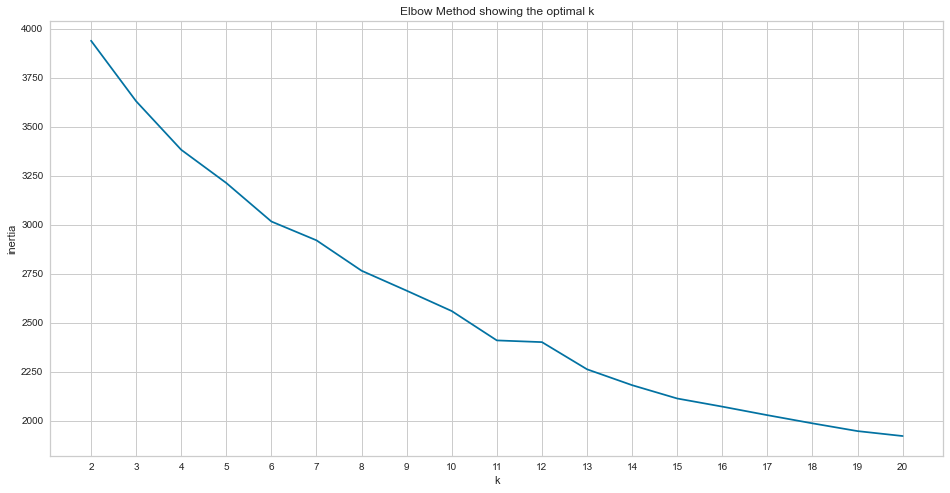

In [127]:
K = range(2, 21)
inertia = []

for k in K:
    print("Training a K-Means model with {} clusters! ".format(k))
    print()
    kmeans = KMeans(n_clusters=k,
                    random_state=1234)
    kmeans.fit(X_scaled_df)
    inertia.append(kmeans.inertia_)

import numpy as np
import matplotlib.pyplot as plt

plt.figure(figsize=(16, 8))
plt.plot(K, inertia, 'bx-')
plt.xlabel('k')
plt.ylabel('inertia')
plt.xticks(np.arange(min(K), max(K) + 1, 1.0))
plt.title('Elbow Method showing the optimal k')

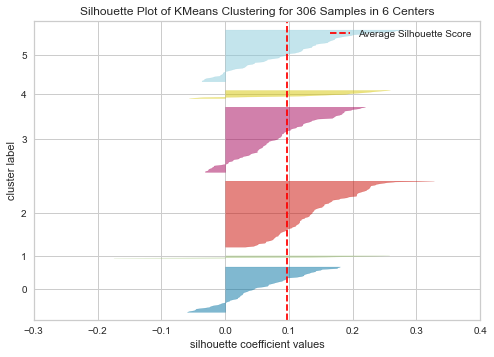

<AxesSubplot:title={'center':'Silhouette Plot of KMeans Clustering for 306 Samples in 6 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [130]:
from yellowbrick.cluster import SilhouetteVisualizer

model = KMeans(6, random_state=42)
visualizer = SilhouetteVisualizer(model, colors='yellowbrick')
visualizer.fit(X_scaled_df)  # Fit the data to the visualizer
visualizer.show()  # Finalize and render the figure

In [129]:
# import pickle
#
# #scaler = StandardScaler()
# #model = KMeans()
#
# with open("Model/scaler.pickle", "wb") as f:
#     pickle.dump(scaler,f)
#
# with open("Model/kmeans_4.pickle", "wb") as f:
#     pickle.dump(kmeans,f)